In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy_gpu as ppy
import pandas as pd
from tqdm import tqdm
from corner import corner
from scipy.stats import ksone
%matplotlib inline

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

Please wait while the GPU states are initialized

In [3]:
res = ppy.results.ResultsPlotter('results/paper2_mock_1.csv')

In [4]:
res.df.tail()

,niter,nc,eff,logl,logwt,logvol,logz,logzerr,h,delta_logz,...,logfeh,logdust,logNpix,tau,dmod,live,log_weights,dynesty_weights,likelihood_weights,weights
6016,2792.0,9.0,18.129,-0.002834,-22.689915,-16.695519,-5.799515,0.167865,4.067124,NaN,...,-0.229550,-0.80164,3.2180,3.62080,29.650,False,-16.890401,4.619470e-08,0.000315,4.619470e-08
6017,2793.0,1.0,18.135,-0.002712,-22.692253,-16.698016,-5.799514,0.167865,4.067124,NaN,...,-0.040548,-1.20160,2.9675,2.49680,28.789,False,-16.892739,4.608682e-08,0.000315,4.608682e-08
6018,3206.0,1.0,19.304,-0.002707,-22.694687,-16.700513,-5.799514,0.167865,4.067124,NaN,...,-0.009662,-1.49050,2.9535,1.86720,28.776,False,-16.895172,4.597480e-08,0.000315,4.597480e-08
6019,2794.0,5.0,18.142,-0.002489,-22.697072,-16.703010,-5.799514,0.167865,4.067124,NaN,...,0.002810,-1.36760,3.0073,2.72280,28.973,False,-16.897558,4.586525e-08,0.000315,4.586525e-08
6020,2795.0,5.0,18.148,-0.002318,-22.699375,-16.705506,-5.799514,0.167865,4.067124,NaN,...,-0.259830,-1.17500,3.0260,0.28332,29.078,False,-16.899860,4.575977e-08,0.000316,4.575977e-08


In [5]:
g = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(),
    ppy.dustmodels.SingleDust(),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance(),
)

In [6]:
true_params = np.array([-0.25, -1.0, 3.0, 2.0, 29.0])

In [7]:
g.set_params(true_params)

In [8]:
data_pcmd, _ = driv.simulate(g, 256)

In [9]:
driv.initialize_data(data_pcmd, n_contours=20)

In [10]:
samples = res.df[res.params].values

In [11]:
old_logls = res.df.logl.values

In [12]:
def temp_logl(params, neff=10000, Nim=256):
    g.set_params(params)
    pcmd_new, _ = driv.simulate(g, Nim)
    _, model_cdf = ppy.utils.contour_fracs(pcmd_new, driv.contours_data)
    if np.any(model_cdf):
        ks_stat = np.max(np.abs(model_cdf - driv.data_cdf))
    else:
        r_mean = np.sqrt(np.sum((np.mean(pcmd_new, axis=1) - driv.data_center)**2))
        ks_stat = np.tanh(driv.tanh_intercept + driv.tanh_slope*r_mean)
    log_like = max(ksone.logsf(ks_stat, neff), -1e4)
    return log_like

In [ ]:
new_logls = np.array([temp_logl(p, neff=10000, Nim=512) for p in tqdm(samples[::10])])

 95%|█████████▍| 571/603 [1:34:52<06:33, 12.29s/it]

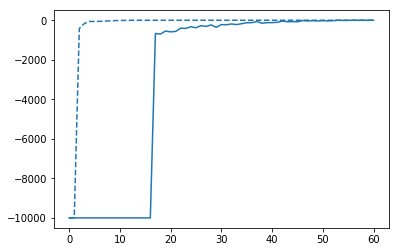

In [18]:
plt.plot(new_logls)
plt.plot(old_logls[::100])

In [19]:
g.set_params(samples[-1])

In [20]:
model_pcmd, _ = driv.simulate(g, 512)

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x2ae99f8f9a58>])

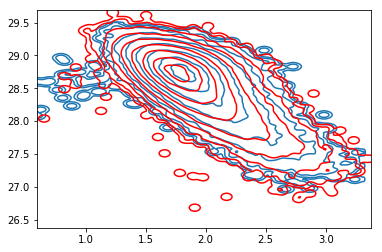

In [26]:
fig, [ax] = ppy.plotting.plot_pcmd_contours(data_pcmd, sig_levels=np.arange(0, 5, 0.5))
ppy.plotting.plot_pcmd_contours(model_pcmd, ax=ax, color='r', sig_levels=np.arange(0, 5, 0.5))

In [28]:
_, model_cdf = ppy.utils.contour_fracs(model_pcmd, driv.contours_data)

In [30]:
model_cdf - driv.data_cdf

array([ 0.0017128 ,  0.00265121,  0.00447845,  0.00438309,  0.00579834,
        0.00664139,  0.00821686,  0.00637436,  0.00649643,  0.00575638,
        0.00375366,  0.00394821,  0.00376129,  0.00350189,  0.0028801 ,
        0.00272369,  0.00070572,  0.00215912, -0.00014114,  0.00057983])